In [1]:
import sys  
sys.path.insert(0, '../classes')

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import math

In [3]:
from data_cleaning import DataCleaner
from data_aggregating import DataAggregator
from lda_modeling import LdaModel
from dtm_modeling import DtmModel
from dtm_evaluation import Evaluator
from data_exploration import Explorer

import datetime


start_time = datetime.datetime.now()
print(f"##################################\nStarting main method at {start_time}\n\n")

#############################################################
# Clean data
#############################################################

# Define all files to be processed
files = ["fp1_projects",
         "fp2_projects",
         "fp3_projects",
         "fp4_projects",
         "fp5_projects",
         "fp6_projects",
         "fp7_projects",
         "h2020_projects"
         ]

cleaner_params = {
    "input_path": "data/",
    "output_path": "output/",
    "file_name": "<<PLACEHOLER>>",
    "sheet_name": "project",
    "date_col_index": ["startDate", "endDate"],
    "id_col": "rcn",
    "text_col": "objective",
    "date_col": "startDate",
    "keep_pos": ["PROPN", "NOUN", "ADJ"],
    "translate": False,
    "add_bigrams": True,
    "bigram_min_count": 50,
    "dict_no_below": 20,
    "dict_no_above": 0.999,
    "additional_stop_words": []
}


#############################################################
# Aggregate data
#############################################################

finish_time = datetime.datetime.now()
print(
    f"##################################\nFinished data cleaning. Total duration was {finish_time - start_time}\n")

aggregator_params = {
    "directory": "../output/",
    "files": files,
    "file_suffix": "_clean.csv",
    "file_format": "csv",
    "date_col": "startDate",
    "target_cols": ["rcn", "startDate", "data_clean", "fp", "fp_no"]
}

aggregator = DataAggregator(**aggregator_params)

# df_agg = aggregator.aggregate_data()
# aggregator.save_to_csv(df_agg)

#############################################################
# Create doc-term-matrix
#############################################################

finish_time = datetime.datetime.now()
print(
    f"##################################\nFinished data aggregation. Total duration was {finish_time - start_time}\n")

# Read already aggregated data
df_agg = aggregator.read_final_from_csv()
# df_agg = df_agg.sample(1000).reset_index(drop=True)

# Get converted cleaned data
cleaner = DataCleaner(**cleaner_params)
data_clean = cleaner.convert_data_clean(df_agg, "data_clean")

# # Load dictionary
dictionary = cleaner.load_dictionary("../assets/dictionary_all_projects")

# Create dtm
doc_term_matrix = cleaner.create_doc_term_matrix(dictionary, data_clean)

model_params = {
    "date_col": "startDate",
    "time_ref_col": "fp_no",  # fp or year
    "path_to_dtm_binary": "assets/dtm-win64.exe",
    "dictionary": dictionary,
    "doc_term_matrix": doc_term_matrix,
    "seed": 0,
    # "num_topics": 50,
    # "num_topics": 30,
    "num_topics": 20,
    # "num_topics": 10,
    # "output_file_path": "models/dtm/200302_dtm_all_projects_50",
    "output_file_path": "../models/dtm/200228_dtm_all_projects_20",
    # "output_file_path": "models/dtm/200301_dtm_all_projects_10",
    # "output_file_path": "models/dtm/200303_dtm_all_projects_30",
    "files": files
}

# Initialize model
dtm_model = DtmModel(**model_params)

#############################################################
# Assign topics and programmes to documents
#############################################################

finish_time = datetime.datetime.now()
print(
    f"##################################\nFinished modeling. Total duration was {finish_time - start_time}\n")

# Load previously saved model
dtm_model.load_model()
#
# #############################################################
# # Aggregate topic detail csv
# #############################################################

topic_dif_files = [f"topic_dif_{i}" for i in range(20)]

# Get aggregated data
aggregator_params = {
    "directory": "../output/topics/",
    "files": topic_dif_files,
    "file_suffix": ".csv",
    "file_format": "csv",
}

# Aggregate raw data with desired information
aggregator = DataAggregator(**aggregator_params)
# df_topics_detail = aggregator.aggregate_data()
# df_topics_detail.to_csv("output/topics/all_topics_detail.csv", index=False, float_format="%.15f", sep=";",
#                         decimal=",")

#############################################################
# Calculate evaluation metrics
#############################################################

finish_time = datetime.datetime.now()
print(
    f"##################################\nFinished calculating Power BI outputs. Total duration was {finish_time - start_time}\n")

evaluator_params = {
    "topic_dif_file_path": "../output/topics/all_topics_detail.csv",
    "files": files,
    "model": dtm_model.model,
    "num_time_slices": 8,
    "doc_term_matrix": doc_term_matrix,
    "dictionary": dictionary,
    "coherence_metric": "u_mass"
}

evaluator = Evaluator(**evaluator_params)

# For time slice lag 1 ##################################
evaluator.transform_topic_dif_data_lag_1()

# Accuracy
tp_tn = evaluator.df_eval["binary_lag_1_tp_tn"].sum()
total = evaluator.df_eval.shape[0]
print(f"Accuracy of binary predictions with time lag 1: \n{tp_tn/total}")

# Correlation
corr = evaluator.df_eval.corr().loc["real_lag_1_pred", "real_lag_1_test"]
print(f"Correlation coefficient between between topic dif values with time lag 1: \n{corr}\n")

# Correlation of differences
corr_dif = evaluator.df_dif_eval.corr().loc["real_dif_lag_1_pred", "real_dif_lag_1_test"]
print(f"Correlation coefficient between between topic dif values with time lag 1: \n{corr_dif}\n")


##################################
Starting main method at 2020-03-29 17:10:45.938653


##################################
Finished data cleaning. Total duration was 0:00:00.002991

##################################
Finished data aggregation. Total duration was 0:00:00.004987

Aggregated file read from ../output/all_projects.csv
Dictionary loaded from ../assets/dictionary_all_projects
Doc-term-matrix created
##################################
Finished modeling. Total duration was 0:00:13.048115

Model loaded from ../models/dtm/200228_dtm_all_projects_20
##################################
Finished calculating Power BI outputs. Total duration was 0:00:13.581713

Topic dif data read from ../output/topics/all_topics_detail.csv
Length of evaluation data set for time slice lag 1: 1861440
Finished transforming topic dif data into evaluation data sets for time slice lag 1
Accuracy of binary predictions with time lag 1: 
0.8397992951693313
Correlation coefficient between between topic dif valu

### Calculate confusion matrix

In [4]:
from sklearn.metrics import confusion_matrix as cm

In [5]:
evaluator.df_eval.head()

,real_lag_1_pred,real_lag_1_test,binary_lag_1_pred,binary_lag_1_test,binary_lag_1_tp_tn
0,1.018445e-04,1.828254e-04,1,1,True
1,1.438954e-04,2.399647e-04,1,1,True
2,4.764599e-06,-5.299984e-07,1,0,False
3,-5.962881e-06,-1.880278e-05,0,0,True
4,-4.402501e-08,-7.369862e-08,0,0,True


In [6]:
y_true = evaluator.df_eval["binary_lag_1_test"]
y_pred = evaluator.df_eval["binary_lag_1_pred"]

tn, fp, fn, tp = cm(y_true, y_pred).ravel()
(tn, fp, fn, tp)

(607894, 209794, 88410, 955342)

In [7]:
tn + fp + fn + tp

1861440

In [8]:
x = evaluator.df_eval["real_lag_1_pred"]
y = evaluator.df_eval["real_lag_1_test"]
print(np.cov(x,y))
print(np.std(x))
print(np.std(y))

[[4.64820910e-09 3.88098222e-09]
 [3.88098222e-09 5.09544002e-09]]
6.817775737568813e-05
7.138233174141341e-05


In [9]:
evaluator.df_eval.shape

(1861440, 5)

0.7948974107327673


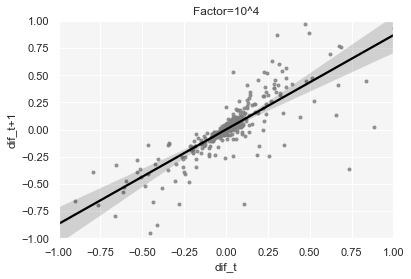

In [10]:
seed = 0
factor= 10000

sns.set(rc={'axes.facecolor':'whitesmoke', 'figure.facecolor':'white'},
        color_codes=True, palette="dark") # palette options: deep, muted, bright, pastel, dark, colorblind

df_eval_sample = evaluator.df_eval.sample(5000, random_state=seed)
# df_eval_sample = evaluator.df_eval
df_eval_sample = df_eval_sample.astype(np.float64)
df_eval_sample = df_eval_sample[(np.abs(stats.zscore(df_eval_sample)) < 3).all(axis=1)]

print(df_eval_sample.corr().loc["real_lag_1_pred", "real_lag_1_test"])

ax = plt.axes(xlim=(-1, 1), ylim=(-1, 1))
ax = sns.regplot(x="real_lag_1_pred", y="real_lag_1_test", 
            data=df_eval_sample*factor, 
            ax=ax, 
            marker=".", 
            scatter_kws={"color":"grey"},
            line_kws={"color":"black"},
           );
ax = ax.set(title=f"Factor=10^{round(math.log(factor, 10))}", xlabel="dif_t", ylabel="dif_t+1")

## Create subplots

In [14]:
def create_regression_plot(df_evaluation, method, seed, factor, ax, sample_size=5000):

    sns.set(rc={'axes.facecolor':'whitesmoke', 'figure.facecolor':'white'},
            color_codes=True, palette="dark") # palette options: deep, muted, bright, pastel, dark, colorblind
    
    # Get sample depending on method
    if method == "random":
        df_eval_sample = df_evaluation.sample(sample_size, random_state=seed)
    elif method == "hot":
        print("na")
    
    # Format as number
    df_eval_sample = df_eval_sample.astype(np.float64)
    
    # Remove outliers
    df_eval_sample = df_eval_sample[(np.abs(stats.zscore(df_eval_sample)) < 3).all(axis=1)]


    ax.set_xlim(left=-1, right=1)
    ax.set_ylim(bottom=-1, top=1)
    sns.regplot(x="real_lag_1_pred", y="real_lag_1_test", 
                data=df_eval_sample*factor, 
                ax=ax, 
                marker=".", 
                scatter_kws={"color":"grey"},
                line_kws={"color":"black"},
                ci=None
               );
    ax.set(title=f"Factor=10^{round(math.log(factor, 10))}", xlabel="Δ_t", ylabel="Δ_t+1") # β
    
    return ax

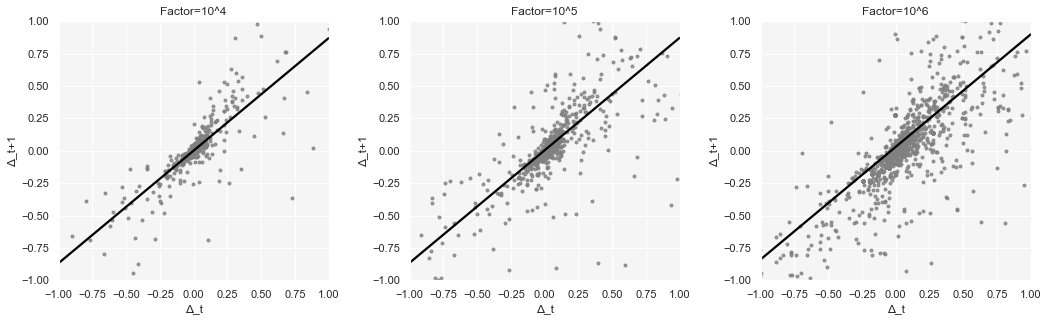

In [15]:
seed = 0
sample_size = 5000
factors= [10000, 100000, 1000000]

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=[15, 4])
fig.tight_layout()
plt.subplots_adjust(left=0.05, bottom=0.05, right=0.95, top=0.95, wspace=0.3, hspace=0.3)

for i in range(len(factors)):
    
    # Get factor
    factor = factors[i]
    
    # Create sub plot
    create_regression_plot(evaluator.df_eval, "random", seed, factor, axs[i], sample_size)

In [13]:
fig.savefig("../images/3_regression_plots")